# Recommendation System Model Fitur 2'
-------------

# Import Library

In [43]:
#Import the library to be used
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math, re, sqlite3, os, tabulate, string, nltk
from scipy.sparse import csr_matrix
conn=sqlite3.connect(":memory:")
import numpy.ma as ma
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp


## Import Dataset

In [44]:
file_path = r'C:\Users\LENOVO\Bangkit 2023\Barkit-ML\DATASET\recommendation system\reco.csv'

if os.path.isfile(file_path):
    df = pd.read_csv(file_path)
    # Process the DataFrame as needed
else:
    print("File not found!")

In [45]:
df.head(6)

,partition_date,orderparentid,user_id,productcontentid,brand_id,category_id,category_name,gender,price,color_id,business_unit,ImageLink
0,20.08.2020 06:00,335057357,86386,39328996,919155,418,Sandalet,Kadın,319.98,14.0,Branded Shoes B,https://cdn.dsmcdn.com//ty1/product/media/images/20200427/20/316534/69600209/4/4_org_zoom.jpg
1,24.08.2020 10:00,337401625,59469,31903343,121,1827,Banyo Dolabı,Unisex,1195.56,3.0,Bahçe & Yapı Market & Hırdavat,https://cdn.dsmcdn.com//assets/product/media/images/20191010/9/355954/57359653/1/1_org_zoom.jpg
2,26.08.2020 19:00,338457012,51248,34726400,40,604,T-Shirt,Kadın,37.99,14.0,PL Woman,https://cdn.dsmcdn.com//assets/product/media/images/20200318/15/4526254/62064217/1/1_org_zoom.jpg
3,22.08.2020 11:00,336681542,29380,32920640,7651,604,T-Shirt,Kadın,24.99,6.0,Kadın A,https://cdn.dsmcdn.com//assets/product/media/images/20191127/17/824912/59665366/1/1_org_zoom.jpg
4,20.08.2020 19:00,335736916,68368,39035716,3395,599,Kazak,Kadın,79.90,16.0,Kadın A,https://cdn.dsmcdn.com//ty1/product/media/images/20200421/13/30718/69068887/1/1_org_zoom.jpg
5,20.08.2020 15:00,335512798,62395,5808634,8605,578,Bikini Altı,Kadın,19.95,17.0,İç Giyim,https://cdn.dsmcdn.com//Assets/ProductImages/oa/59/5808634/1/6300250720715_1_org_zoom.jpg


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508228 entries, 0 to 508227
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   partition_date    508228 non-null  object 
 1   orderparentid     508228 non-null  int64  
 2   user_id           508228 non-null  int64  
 3   productcontentid  508228 non-null  int64  
 4   brand_id          508228 non-null  int64  
 5   category_id       508228 non-null  int64  
 6   category_name     508228 non-null  object 
 7   gender            475493 non-null  object 
 8   price             508228 non-null  float64
 9   color_id          375670 non-null  float64
 10  business_unit     508228 non-null  object 
 11  ImageLink         508228 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 46.5+ MB


# Data Preprocessing
-----

## Data Cleaning and Feature Selection

In [47]:
df.drop(['partition_date', 'ImageLink'], axis=1, inplace=True)

Product and Image Link columns from main dataset is cataloged.

In [48]:
pd.set_option('display.max_colwidth', None)
df.drop(df.index[2001:508229], inplace=True)
df.isna().isnull()
df.dropna(axis=0, inplace=True)

In [49]:
df.tail()

,orderparentid,user_id,productcontentid,brand_id,category_id,category_name,gender,price,color_id,business_unit
1995,333263499,17811,45347236,7651,563,Pijama Takımı,Erkek,39.99,16.0,Kids & Baby Fashion
1996,334653044,77838,44417375,7546,387,Saat,Unisex,185.91,14.0,Saat B
1997,333207192,78992,4319030,16494,982,Yürüteç,Unisex,160.00,3.0,Çocuk Gereç
1998,327863198,41521,38845834,9861,647,Göz Farı,Kadın,35.70,3.0,Makyaj
2000,325104180,70381,164037,1430,2242,Banyo Aksesuarı,Unisex,51.70,3.0,Banyo


In [50]:
df.dropna(axis=0, inplace=True)

In [51]:
gender_names = df['gender'].unique()
print(gender_names)

['Kadın' 'Unisex' 'Erkek']


In [52]:
df.loc[df['gender'] == 'Kadın', 'gender'] = 'wanita'
df.loc[df['gender'] == 'Erkek', 'gender'] = 'pria'
df.loc[df['gender'] == 'Unisex', 'gender'] = 'pria'
print(df['gender'].head(10))

0     wanita
1       pria
2     wanita
3     wanita
4     wanita
5     wanita
6     wanita
8       pria
10      pria
11      pria
Name: gender, dtype: object


In [53]:
gender_names = df['category_name'].unique()
print(gender_names)

['Sandalet' 'Banyo Dolabı' 'T-Shirt' 'Kazak' 'Bikini Altı' 'Elbise'
 'Kamp Sandalyesi' 'Sneaker' 'BB & CC Krem' 'Sweatshirt'
 'Fırın&Kek Kalıbı' 'Alt-Üst Takım' 'Mouse' 'Bebek Takımları'
 'Pratik Mutfak Gereçleri' 'Terlik' 'Polo Yaka T-shirt' 'Tayt' 'Çorap'
 'Saç Fırçası ve Tarak' 'Atlet' 'Şapka' 'Gümüş Kolye'
 'Klasik Topuklu Ayakkabı' 'Diğer Hazırlık Gereçleri' 'Güneş Gözlüğü'
 'Mont' 'Spor T-Shirt' 'Gömlek' 'Tulum' 'Saç Düzleştirici' 'Sütyen'
 'Yastık' 'Saat' 'Kavanoz & Saklama Kabı' 'Etek' 'Düzenleyici'
 'Saklama Kutusu&Sepet&Hurç' 'Akıllı Saat' 'Banyo Aksesuarı'
 'Eşofman Altı' 'Casual Ayakkabı' 'Gümüş Bileklik' 'Bluz' 'Ceket'
 'Saksılık' 'Fitness - Kondisyon' 'Oyuncak Silah & Su Tabancası' 'Boxer'
 'Yürüyüş Ayakkabısı' 'Kapak & Kılıf' 'Pantolon' 'Tablo' 'Ayakkabılık'
 'Kemer' 'Bijuteri Kolye' 'Şort & Bermuda' 'Bikini Üstü' 'Parfüm'
 'Kumandalı Oyuncaklar' 'Jeans' 'Babet' 'Omuz Çantası' 'Kaşıklık' 'Hırka'
 'Mayo' 'Masa Örtüsü' 'Yatak' 'Kırlent & Kırlent Kılıfı'
 'Tesettür Alt-Üst 

In [54]:
df.head()

,orderparentid,user_id,productcontentid,brand_id,category_id,category_name,gender,price,color_id,business_unit
0,335057357,86386,39328996,919155,418,Sandalet,wanita,319.98,14.0,Branded Shoes B
1,337401625,59469,31903343,121,1827,Banyo Dolabı,pria,1195.56,3.0,Bahçe & Yapı Market & Hırdavat
2,338457012,51248,34726400,40,604,T-Shirt,wanita,37.99,14.0,PL Woman
3,336681542,29380,32920640,7651,604,T-Shirt,wanita,24.99,6.0,Kadın A
4,335736916,68368,39035716,3395,599,Kazak,wanita,79.90,16.0,Kadın A


In [55]:
for column in df.category_name:
    df['category_name'] = df['category_name'].replace('Sandalet', 'speaker')
    df['category_name'] = df['category_name'].replace( 'Banyo Dolabı' , 'camera')
    df['category_name'] = df['category_name'].replace('T-Shirt', 'matras')
    df['category_name'] = df['category_name'].replace( 'Kazak' , 'PS')
    df['category_name'] = df['category_name'].replace('Bikini Altı' , 'projector')
    df['category_name'] = df['category_name'].replace('Elbise', 'tas')
    df['category_name'] = df['category_name'].replace( 'Kamp Sandalyesi' , 'tenda')
    df['category_name'] = df['category_name'].replace('Sneaker' , 'sepatu')
    df['category_name'] = df['category_name'].replace('BB & CC Krem' , 'laptop')
    df['category_name'] = df['category_name'].replace('Sweatshirt', 'mouse')
    df['category_name'] = df['category_name'].replace( 'Fırın&Kek Kalıbı', 'keyboard')
    df['category_name'] = df['category_name'].replace( 'Alt-Üst Takım' , 'komputer')
    df['category_name'] = df['category_name'].replace('Mouse', 'charger laptop')
    df['category_name'] = df['category_name'].replace( 'Bebek Takımları', 'handphone')
    df['category_name'] = df['category_name'].replace( 'Pratik Mutfak Gereçleri' , 'tripod')
    df['category_name'] = df['category_name'].replace('Terlik' , 'headset')
    df['category_name'] = df['category_name'].replace('Polo Yaka T-shirt', 'tenda')
    df['category_name'] = df['category_name'].replace( 'Tayt' , 'lampu studio')
    df['category_name'] = df['category_name'].replace('Çorap', 'kustom')
    df['category_name'] = df['category_name'].replace( 'Saç Fırçası ve Tarak', 'properti')
    df['category_name'] = df['category_name'].replace( 'Atlet' , 'bor')
    df['category_name'] = df['category_name'].replace('Şapka' , 'mesin cuci')
    df['category_name'] = df['category_name'].replace('Gümüş Kolye', 'pemotong rumput')
    df['category_name'] = df['category_name'].replace( 'Klasik Topuklu Ayakkabı' , 'generator')
    df['category_name'] = df['category_name'].replace('Diğer Hazırlık Gereçleri' , 'sleeping bag')
    df['category_name'] = df['category_name'].replace('Güneş Gözlüğü', 'speaker')
    df['category_name'] = df['category_name'].replace( 'Mont' , 'camera')
    df['category_name'] = df['category_name'].replace('Spor T-Shirt', 'matras')
    df['category_name'] = df['category_name'].replace( 'Gömlek' , 'PS')
    df['category_name'] = df['category_name'].replace('Tulum' , 'projector')
    df['category_name'] = df['category_name'].replace('Saç Düzleştirici' , 'tas')
    df['category_name'] = df['category_name'].replace('Sütyen', 'tenda')
    df['category_name'] = df['category_name'].replace( 'Yastık' , 'sepatu')
    df['category_name'] = df['category_name'].replace('Saat' , 'laptop')
    df['category_name'] = df['category_name'].replace('Kavanoz & Saklama Kabı' , 'mouse')
    df['category_name'] = df['category_name'].replace('Etek' , 'keyboard')
    df['category_name'] = df['category_name'].replace('Düzenleyici', 'komputer')
    df['category_name'] = df['category_name'].replace( 'Saklama Kutusu&Sepet&Hurç', 'charger laptop')
    df['category_name'] = df['category_name'].replace( 'Akıllı Saat' , 'handphone')
    df['category_name'] = df['category_name'].replace('Banyo Aksesuarı', 'tripod')
    df['category_name'] = df['category_name'].replace( 'Eşofman Altı' , 'headset')
    df['category_name'] = df['category_name'].replace('Casual Ayakkabı' , 'tenda')
    df['category_name'] = df['category_name'].replace('Gümüş Bileklik' , 'lampu studio')
    df['category_name'] = df['category_name'].replace('Bluz' , 'kustom')
    df['category_name'] = df['category_name'].replace('Ceket', 'properti')
    df['category_name'] = df['category_name'].replace( 'Saksılık' , 'bor')
    df['category_name'] = df['category_name'].replace('Fitness - Kondisyon' , 'mesin cuci')
    df['category_name'] = df['category_name'].replace('Oyuncak Silah & Su Tabancası' , 'pemotong rumput')
    df['category_name'] = df['category_name'].replace('Boxer', 'generator')
    df['category_name'] = df['category_name'].replace( 'Yürüyüş Ayakkabısı' , 'sleeping bag')
    df['category_name'] = df['category_name'].replace('Kapak & Kılıf', 'speaker')
    df['category_name'] = df['category_name'].replace( 'Pantolon' , 'camera')
    df['category_name'] = df['category_name'].replace('Tablo', 'matras')
    df['category_name'] = df['category_name'].replace( 'Ayakkabılık', 'PS')
    df['category_name'] = df['category_name'].replace( 'Kemer' , 'projector')
    df['category_name'] = df['category_name'].replace('Bijuteri Kolye' , 'tas')
    df['category_name'] = df['category_name'].replace('Şort & Bermuda' , 'tenda')
    df['category_name'] = df['category_name'].replace('Bikini Üstü' , 'sepatu')
    df['category_name'] = df['category_name'].replace('Parfüm', 'laptop')
    df['category_name'] = df['category_name'].replace( 'Kumandalı Oyuncaklar', 'mouse')
    df['category_name'] = df['category_name'].replace( 'Jeans' , 'keyboard')
    df['category_name'] = df['category_name'].replace('Babet', 'komputer')
    df['category_name'] = df['category_name'].replace( 'Omuz Çantası' , 'charger laptop')
    df['category_name'] = df['category_name'].replace('Kaşıklık' , 'handphone')
    df['category_name'] = df['category_name'].replace('Hırka', 'tripod')
    df['category_name'] = df['category_name'].replace( 'Mayo' , 'headset')
    df['category_name'] = df['category_name'].replace('Masa Örtüsü' , 'tenda')
    df['category_name'] = df['category_name'].replace('Yatak' , 'lampu studio')
    df['category_name'] = df['category_name'].replace('Kırlent & Kırlent Kılıfı', 'kustom')
    df['category_name'] = df['category_name'].replace('Tesettür Alt-Üst Takım' , 'properti')
    df['category_name'] = df['category_name'].replace('Gözlük Aksesuarı', 'bor')
    df['category_name'] = df['category_name'].replace( 'Dambıllar ve Ağırlık Plakaları', 'mesin cuci')
    df['category_name'] = df['category_name'].replace( 'Spor Sütyeni', 'pemotong rumput')
    df['category_name'] = df['category_name'].replace( 'Spor Eşofman Takımı', 'generator')
    df['category_name'] = df['category_name'].replace( 'Notebook Soğutucu', 'sleeping bag')
    df['category_name'] = df['category_name'].replace( 'Kaş Kalemi&Kaş Farı' , 'speaker')
    df['category_name'] = df['category_name'].replace('Ruj', 'camera')
    df['category_name'] = df['category_name'].replace( 'Zigon' , 'matras')
    df['category_name'] = df['category_name'].replace('Saç Maşası', 'PS')
    df['category_name'] = df['category_name'].replace( 'Eşofman Takımı', 'projector')
    df['category_name'] = df['category_name'].replace( 'Parfüm Seti' , 'tas')
    df['category_name'] = df['category_name'].replace('Duvar Saati' , 'tenda')
    df['category_name'] = df['category_name'].replace('Göz Farı' , 'sepatu')
    df['category_name'] = df['category_name'].replace('Spor Şort', 'laptop')
    df['category_name'] = df['category_name'].replace( 'Lambader' , 'mouse')
    df['category_name'] = df['category_name'].replace('Suluk & Matara' , 'keyboard')
    df['category_name'] = df['category_name'].replace('Kahvaltı Takımı', 'komputer')
    df['category_name'] = df['category_name'].replace( 'Abiye & Mezuniyet Elbisesi', 'charger laptop')
    df['category_name'] = df['category_name'].replace( 'Scooter' , 'handphone')
    df['category_name'] = df['category_name'].replace('Akrilik Boya', 'tripod')
    df['category_name'] = df['category_name'].replace( 'Çift Kişilik Nevresim' , 'headset')
    df['category_name'] = df['category_name'].replace('Çift Kişilik Pike&Pike Takımı', 'tenda')
    df['category_name'] = df['category_name'].replace( 'Diğer Dekoratif Aksesuarlar', 'lampu studio')
    df['category_name'] = df['category_name'].replace( 'Bot & Bootie' , 'kustom')
    df['category_name'] = df['category_name'].replace('Süzgeç', 'properti')
    df['category_name'] = df['category_name'].replace( 'Yüz Temizleme Cihazı', 'bor')
    df['category_name'] = df['category_name'].replace( 'Tencere&Tencere Seti' , 'mesin cuci')
    df['category_name'] = df['category_name'].replace('Havlu&Havlu Seti' , 'pemotong rumput')
    df['category_name'] = df['category_name'].replace('Kase', 'generator')
    df['category_name'] = df['category_name'].replace( 'Pareo' , 'sleeping bag')
    df['category_name'] = df['category_name'].replace('Kaşık' , 'speaker')
    df['category_name'] = df['category_name'].replace('Keçeli Kalemler' , 'camera')
    df['category_name'] = df['category_name'].replace('Portbebe & Kanguru', 'matras')
    df['category_name'] = df['category_name'].replace( 'Ev Terliği', 'PS')
    df['category_name'] = df['category_name'].replace( 'Çalışma Masası', 'projector')
    df['category_name'] = df['category_name'].replace( 'Fondöten' , 'tas')
    df['category_name'] = df['category_name'].replace('Cüzdan' , 'tenda')
    df['category_name'] = df['category_name'].replace('Spor Terlik', 'sepatu')
    df['category_name'] = df['category_name'].replace( 'Gecelik' , 'laptop')
    df['category_name'] = df['category_name'].replace('Epilatör', 'mouse')
    df['category_name'] = df['category_name'].replace( 'Duvar Rafı', 'keyboard')
    df['category_name'] = df['category_name'].replace( 'Pijama Takımı' , 'komputer')
    df['category_name'] = df['category_name'].replace('Tesettür Abiye' , 'charger laptop')
    df['category_name'] = df['category_name'].replace('Bardak' , 'handphone')
    df['category_name'] = df['category_name'].replace('Fantezi Gecelik', 'tripod')
    df['category_name'] = df['category_name'].replace( 'Deniz Şortu' , 'headset')
    df['category_name'] = df['category_name'].replace('Plaj Çantası' , 'tenda')
    df['category_name'] = df['category_name'].replace('Mum & Koku' , 'lampu studio')
    df['category_name'] = df['category_name'].replace('Tesettür Tunik' , 'kustom')
    df['category_name'] = df['category_name'].replace('Askılık', 'properti')
    df['category_name'] = df['category_name'].replace( 'Hamile Gecelik', 'bor')
    df['category_name'] = df['category_name'].replace( 'Peluş Oyuncaklar' , 'mesin cuci')
    df['category_name'] = df['category_name'].replace('Korse' , 'pemotong rumput')
    df['category_name'] = df['category_name'].replace('Servis&Sunum Ürünleri', 'generator')
    df['category_name'] = df['category_name'].replace( 'Pudra' , 'sleeping bag')
    df['category_name'] = df['category_name'].replace('Maskara' , 'speaker')
    df['category_name'] = df['category_name'].replace('Saç Boyası' , 'camera')
    df['category_name'] = df['category_name'].replace('Tüy Alma Cihazı' , 'matras')
    df['category_name'] = df['category_name'].replace('Spor Tayt' , 'PS')
    df['category_name'] = df['category_name'].replace('Çamaşırlık', 'projector')
    df['category_name'] = df['category_name'].replace( 'Tükenmez Kalemler' , 'tas')
    df['category_name'] = df['category_name'].replace('Forma' , 'tenda')
    df['category_name'] = df['category_name'].replace('Büyük Beden Tunik' , 'sepatu')
    df['category_name'] = df['category_name'].replace('Hastane Çıkışları', 'laptop')
    df['category_name'] = df['category_name'].replace( 'Dişlik ve Çıngırak' , 'mouse')
    df['category_name'] = df['category_name'].replace('Külot' , 'keyboard')
    df['category_name'] = df['category_name'].replace('Avize', 'komputer')
    df['category_name'] = df['category_name'].replace( 'Dekoratif Ürünler' , 'charger laptop')
    df['category_name'] = df['category_name'].replace('Slip', 'handphone')
    df['category_name'] = df['category_name'].replace( 'Büyük Beden T-Shirt', 'tripod')
    df['category_name'] = df['category_name'].replace( 'Oyun Çadırı' , 'headset')
    df['category_name'] = df['category_name'].replace('Sürahi& Karaf' , 'tenda')
    df['category_name'] = df['category_name'].replace('Dudak Parlatıcısı', 'lampu studio')
    df['category_name'] = df['category_name'].replace( 'Oyun Hamurları' , 'kustom')
    df['category_name'] = df['category_name'].replace('Spor Eşofman Altı' , 'properti')
    df['category_name'] = df['category_name'].replace('Çaydanlık', 'bor')
    df['category_name'] = df['category_name'].replace( 'Ekmek Kutusu ve Sepetleri' , 'mesin cuci')
    df['category_name'] = df['category_name'].replace('Biblo', 'pemotong rumput')
    df['category_name'] = df['category_name'].replace( 'Puf & Bench' , 'generator')
    df['category_name'] = df['category_name'].replace('Rende' , 'sleeping bag')
    df['category_name'] = df['category_name'].replace('Okul Çantası', 'speaker')
    df['category_name'] = df['category_name'].replace( 'Kaban', 'camera')
    df['category_name'] = df['category_name'].replace( 'Bulaşıklık', 'matras')
    df['category_name'] = df['category_name'].replace( 'Postacı Çantası' , 'PS')
    df['category_name'] = df['category_name'].replace('Pratik Temizlik Gereci', 'projector')
    df['category_name'] = df['category_name'].replace( 'Fantezi İç Çamaşır Takımları' , 'tas')
    df['category_name'] = df['category_name'].replace('Vantilatör' , 'tenda')
    df['category_name'] = df['category_name'].replace('Takım Elbise' , 'sepatu')
    df['category_name'] = df['category_name'].replace('Plaj Havlusu', 'laptop')
    df['category_name'] = df['category_name'].replace( 'Bikini Takımı' , 'mouse')
    df['category_name'] = df['category_name'].replace('Klozet Takımı' , 'keyboard')
    df['category_name'] = df['category_name'].replace('Body' , 'komputer')
    df['category_name'] = df['category_name'].replace('Gümüş Yüzük' , 'charger laptop')
    df['category_name'] = df['category_name'].replace('Bijuteri Halhal', 'handphone')
    df['category_name'] = df['category_name'].replace('Aktivite Masası & Merkezi', 'tripod')
    df['category_name'] = df['category_name'].replace( 'Çok Amaçlı Dolaplar', 'headset')
    df['category_name'] = df['category_name'].replace( 'Eşarp', 'tenda')
    df['category_name'] = df['category_name'].replace( 'Yelek', 'lampu studio')
    df['category_name'] = df['category_name'].replace( 'Büyük Beden Elbise', 'kustom')
    df['category_name'] = df['category_name'].replace( 'Pijama Altı', 'properti')
    df['category_name'] = df['category_name'].replace( 'Gümüş Set & Takım' , 'bor')
    df['category_name'] = df['category_name'].replace('Abiye Çanta', 'mesin cuci')
    df['category_name'] = df['category_name'].replace( 'Salıncak & Hamak' , 'pemotong rumput')
    df['category_name'] = df['category_name'].replace('Loafer Ayakkabı' , 'generator')
    df['category_name'] = df['category_name'].replace('Spor Çorap' , 'sleeping bag')
    df['category_name'] = df['category_name'].replace('Aydınlatıcı', 'speaker')
    df['category_name'] = df['category_name'].replace( 'Ofis Aksesuarları' , 'camera')
    df['category_name'] = df['category_name'].replace('Göz Kalemi' , 'matras')
    df['category_name'] = df['category_name'].replace('Astronot Tulum' , 'PS')
    df['category_name'] = df['category_name'].replace('Çelik Kolye', 'projector')
    df['category_name'] = df['category_name'].replace( 'Tuşlu Cep Telefonu' , 'tas')
    df['category_name'] = df['category_name'].replace('Akıllı Saat Kordon' , 'tenda')
    df['category_name'] = df['category_name'].replace('Deniz Ayakkabısı', 'sepatu')
    df['category_name'] = df['category_name'].replace( 'Akıllı Cep Telefonu' , 'laptop')
    df['category_name'] = df['category_name'].replace('Saç Bandı' , 'mouse')
    df['category_name'] = df['category_name'].replace('Tabak' , 'keyboard')
    df['category_name'] = df['category_name'].replace('Çerçeve & Fotoğraf Albümü', 'komputer')
    df['category_name'] = df['category_name'].replace( 'Yağmurluk&Rüzgarlık', 'charger laptop')
    df['category_name'] = df['category_name'].replace( 'Banyo Düzenleyici', 'handphone')
    df['category_name'] = df['category_name'].replace( 'El Çantası' , 'tripod')
    df['category_name'] = df['category_name'].replace('Kamp Matarası', 'headset')
    df['category_name'] = df['category_name'].replace( 'Foto & Kamera Aksesuarları' , 'tenda')
    df['category_name'] = df['category_name'].replace('Sırt Çantası', 'lampu studio')
    df['category_name'] = df['category_name'].replace( 'Bijuteri Bileklik', 'kustom')
    df['category_name'] = df['category_name'].replace( 'Banyo Setleri' , 'properti')
    df['category_name'] = df['category_name'].replace('Tunik' , 'bor')
    df['category_name'] = df['category_name'].replace('Tıraş Makinesi', 'mesin cuci')
    df['category_name'] = df['category_name'].replace( 'Kapatıcı' , 'pemotong rumput')
    df['category_name'] = df['category_name'].replace('Kuru Boya Kalemi', 'generator')
    df['category_name'] = df['category_name'].replace( 'Hamile Elbisesi', 'sleeping bag')
    df['category_name'] = df['category_name'].replace( 'Diğer Parti Malzemeleri', 'speaker')
    df['category_name'] = df['category_name'].replace( 'Basketbol Topu', 'camera')
    df['category_name'] = df['category_name'].replace( 'Halı', 'matras')
    df['category_name'] = df['category_name'].replace( 'Abiye Ayakkabı', 'PS')
    df['category_name'] = df['category_name'].replace( 'Bebek Bakım Çantası' , 'projector')
    df['category_name'] = df['category_name'].replace('Takma Tırnak ve Aksesuarları', 'tas')
    df['category_name'] = df['category_name'].replace( 'Trençkot' , 'tenda')
    df['category_name'] = df['category_name'].replace('Yürüteç' , 'sepatu')
    df['category_name'] = df['category_name'].replace('Kedi Oyuncakları' , 'laptop')
    df['category_name'] = df['category_name'].replace('Çadır', 'mouse')
    df['category_name'] = df['category_name'].replace( 'Büstiyer', 'keyboard')
    df['category_name'] = df['category_name'].replace( 'Lego & Yapı Oyuncakları' , 'komputer')
    df['category_name'] = df['category_name'].replace('Gümüş Küpe' , 'charger laptop')
    df['category_name'] = df['category_name'].replace('Jartiyer', 'handphone')
    df['category_name'] = df['category_name'].replace( 'Runner&Amerikan Servisi' , 'tripod')
    df['category_name'] = df['category_name'].replace('Çocuk Scooterı' , 'headset')
    df['category_name'] = df['category_name'].replace('Bornoz' , 'tenda')
    df['category_name'] = df['category_name'].replace('Çalışma Sandalyesi', 'lampu studio')
    df['category_name'] = df['category_name'].replace( 'Karyola' , 'kustom')
    df['category_name'] = df['category_name'].replace('Tek Kişilik Yorgan', 'properti')
    df['category_name'] = df['category_name'].replace( 'Bardak Altlığı', 'bor')
    df['category_name'] = df['category_name'].replace( 'Plaj Elbisesi', 'mesin cuci')
    df['category_name'] = df['category_name'].replace( 'Tesettür Bone' , 'pemotong rumput')
    df['category_name'] = df['category_name'].replace('Çocuk Bisikleti', 'generator')
    df['category_name'] = df['category_name'].replace( 'Plaj Oyuncakları' , 'sleeping bag')
    df['category_name'] = df['category_name'].replace('Tesettür Hırka', 'speaker')
    df['category_name'] = df['category_name'].replace( 'Valiz & Bavul', 'camera')
    df['category_name'] = df['category_name'].replace( 'Oyuncu Koltuğu', 'matras')
    df['category_name'] = df['category_name'].replace( 'Çizme' , 'PS')
    df['category_name'] = df['category_name'].replace('Bijuteri Küpe' , 'projector')
    df['category_name'] = df['category_name'].replace('Portmanto', 'tas')
    df['category_name'] = df['category_name'].replace( 'Bebek&Çocuk Yorgan', 'tenda')
    df['category_name'] = df['category_name'].replace( 'Fantezi String' , 'sepatu')
    df['category_name'] = df['category_name'].replace('Şal' , 'laptop')
    df['category_name'] = df['category_name'].replace('Kaykay' , 'mouse')
    df['category_name'] = df['category_name'].replace('Koltuk Örtüsü', 'keyboard')
    df['category_name'] = df['category_name'].replace( 'Tuvalet Fırçası' , 'komputer')
    df['category_name'] = df['category_name'].replace('Ahşap Oyuncaklar', 'charger laptop')
    df['category_name'] = df['category_name'].replace( 'Toka', 'handphone')
    df['category_name'] = df['category_name'].replace( 'Çelik Küpe', 'tripod')
    df['category_name'] = df['category_name'].replace( 'Mutfak Havlusu&Kurulama Bezi', 'headset')
    df['category_name'] = df['category_name'].replace( 'Kimono&Kaftan', 'tenda')
    df['category_name'] = df['category_name'].replace( 'Dalış Aksesuarları', 'lampu studio')
    df['category_name'] = df['category_name'].replace( 'Fon Perde' , 'kustom')
    df['category_name'] = df['category_name'].replace('Büyük Beden Abiye Elbise' , 'properti')
    df['category_name'] = df['category_name'].replace('Bebek Banyo Aksesuarları', 'bor')
    df['category_name'] = df['category_name'].replace( 'Diş Fırçalık' , 'mesin cuci')
    df['category_name'] = df['category_name'].replace('Gözlük Kabı' , 'pemotong rumput')
    df['category_name'] = df['category_name'].replace('Tek Kişilik Pike&Pike Takımı', 'generator')
    df['category_name'] = df['category_name'].replace( 'İç çamaşırı takımları', 'sleeping bag')
    df['category_name'] = df['category_name'].replace( 'Shaker & Aksesuarlar' , 'speaker')
    df['category_name'] = df['category_name'].replace('Baharatlık', 'camera')
    df['category_name'] = df['category_name'].replace( 'Ayna', 'matras')
    df['category_name'] = df['category_name'].replace( 'Kitaplık', 'PS')
    df['category_name'] = df['category_name'].replace( 'Kupa&Kupa Takımı' , 'projector')
    df['category_name'] = df['category_name'].replace('TV Sehpaları & Üniteleri' , 'tas')
    df['category_name'] = df['category_name'].replace('Taç', 'tenda')
    df['category_name'] = df['category_name'].replace( 'Oyun Halısı', 'sepatu')
    df['category_name'] = df['category_name'].replace( 'Figür Oyuncaklar' , 'laptop')
    df['category_name'] = df['category_name'].replace('Bebek Body & Zıbın', 'mouse')
    df['category_name'] = df['category_name'].replace( 'Makyaj Çantası', 'keyboard')
    df['category_name'] = df['category_name'].replace( 'Spor Malzemeleri' , 'komputer')
    df['category_name'] = df['category_name'].replace('Abajur' , 'charger laptop')
    df['category_name'] = df['category_name'].replace('Diğer Saç Aksesuarları', 'handphone')


In [56]:
df.head()

,orderparentid,user_id,productcontentid,brand_id,category_id,category_name,gender,price,color_id,business_unit
0,335057357,86386,39328996,919155,418,speaker,wanita,319.98,14.0,Branded Shoes B
1,337401625,59469,31903343,121,1827,camera,pria,1195.56,3.0,Bahçe & Yapı Market & Hırdavat
2,338457012,51248,34726400,40,604,matras,wanita,37.99,14.0,PL Woman
3,336681542,29380,32920640,7651,604,matras,wanita,24.99,6.0,Kadın A
4,335736916,68368,39035716,3395,599,PS,wanita,79.90,16.0,Kadın A


In [57]:
gender_names = df['category_name'].unique()
print(gender_names)

['speaker' 'camera' 'matras' 'PS' 'projector' 'tas' 'tenda' 'sepatu'
 'laptop' 'mouse' 'keyboard' 'komputer' 'charger laptop' 'handphone'
 'tripod' 'headset' 'lampu studio' 'kustom' 'properti' 'bor' 'mesin cuci'
 'pemotong rumput' 'generator' 'sleeping bag']


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1422 entries, 0 to 2000
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   orderparentid     1422 non-null   int64  
 1   user_id           1422 non-null   int64  
 2   productcontentid  1422 non-null   int64  
 3   brand_id          1422 non-null   int64  
 4   category_id       1422 non-null   int64  
 5   category_name     1422 non-null   object 
 6   gender            1422 non-null   object 
 7   price             1422 non-null   float64
 8   color_id          1422 non-null   float64
 9   business_unit     1422 non-null   object 
dtypes: float64(2), int64(5), object(3)
memory usage: 122.2+ KB


*  **orderparentid**: The order id that all the product user bought in one order. 
*  **user_id**: Id of the user.
*  **productcontentid**: Id of the product.
*  **brand_id**: Id of the brand that products have.
*  **category_id** : Id of the category that product included.
*  **category_name**: Name of the category that product included.
*  **gender**: Gender assigned to the product.
*  **price**: Price of product.
*  **color_id**: Id of the color that products have.
*  **business_unit**: Business unit that products have

# Exploratory Data Analysis
-----

## Categori Insight

In [59]:
category=pd.DataFrame(df.groupby('category_name').size())
category.rename(columns={0:'size'},inplace=True)
category.sort_values(by='size',ascending=False,inplace=True)
category.reset_index(inplace=True)

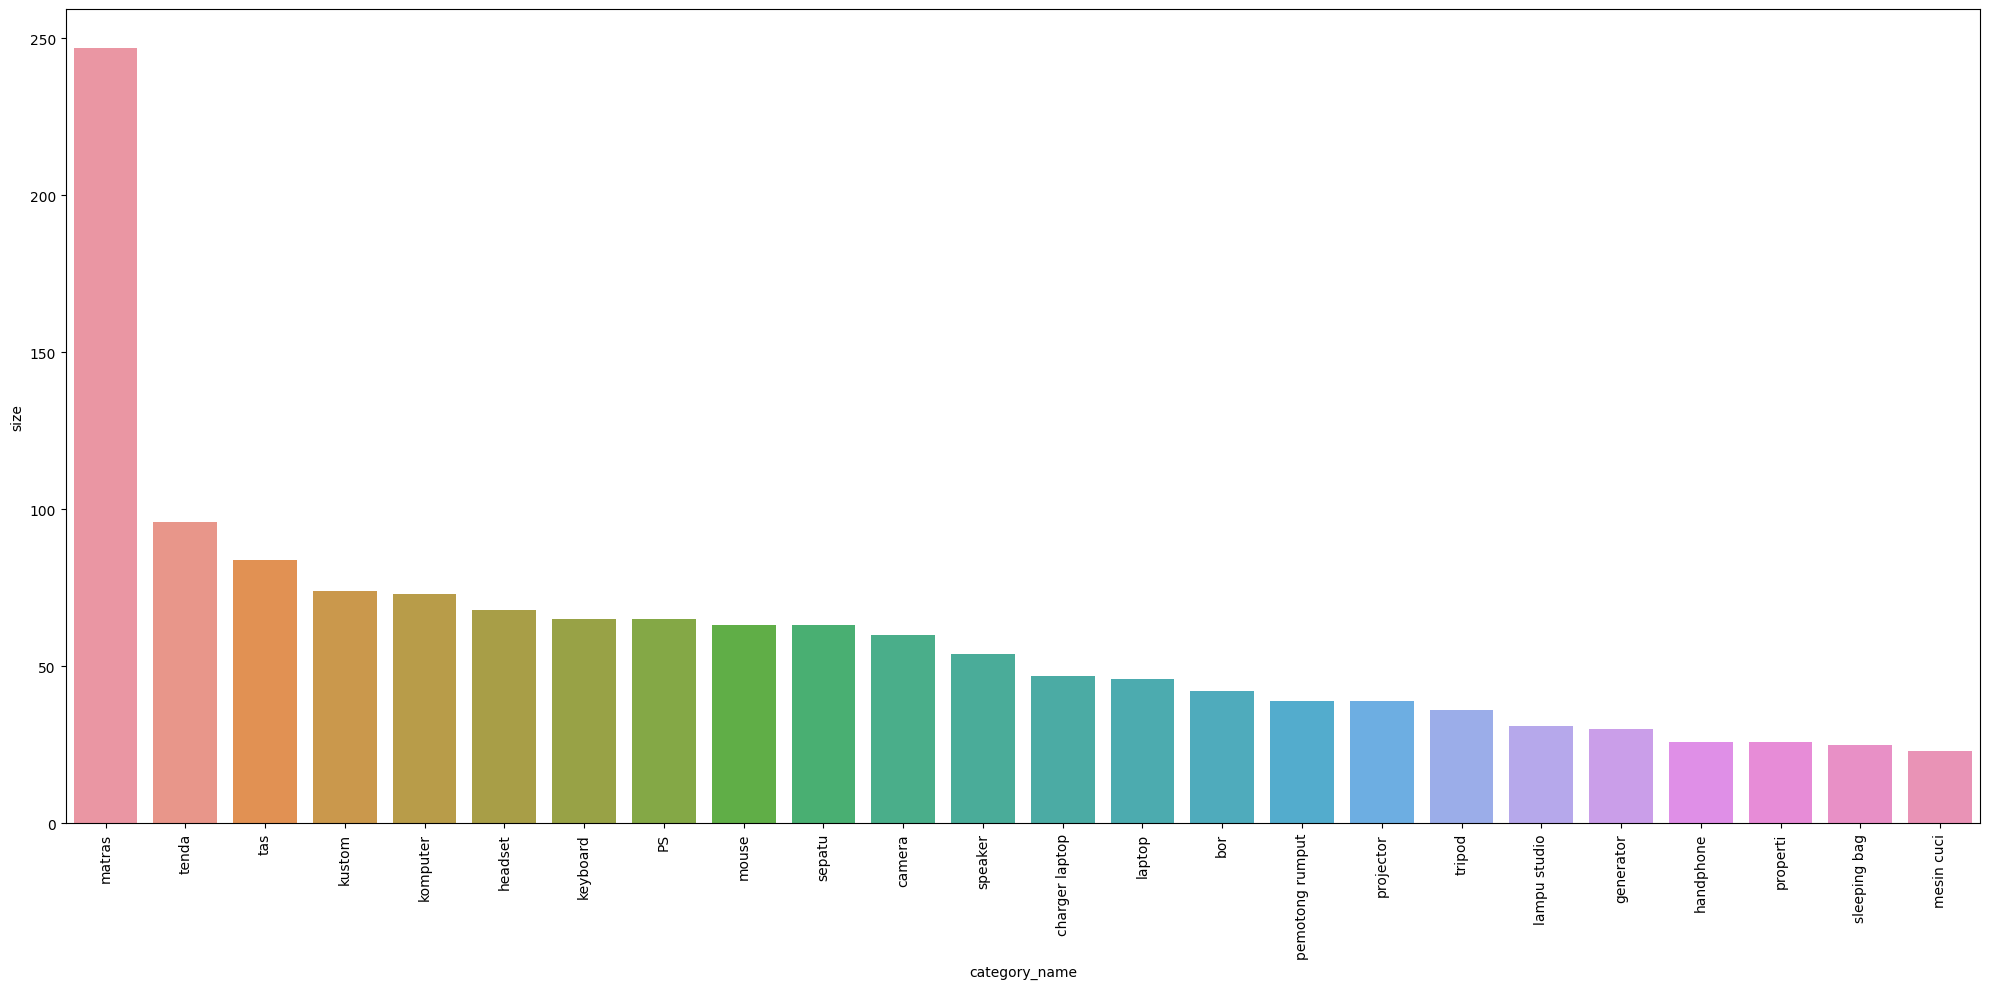

In [60]:
plt.figure(figsize=(20,10))
ax=sns.barplot(x='category_name',y='size',data=category.head(100))
plt.xticks(rotation=90)
plt.tight_layout()

## Business Unit Insight

In [61]:
bu=pd.DataFrame(df.groupby('business_unit').size())
bu.rename(columns={0:'size'},inplace=True)
bu.sort_values(by='size',ascending=False,inplace=True)
bu.reset_index(inplace=True)

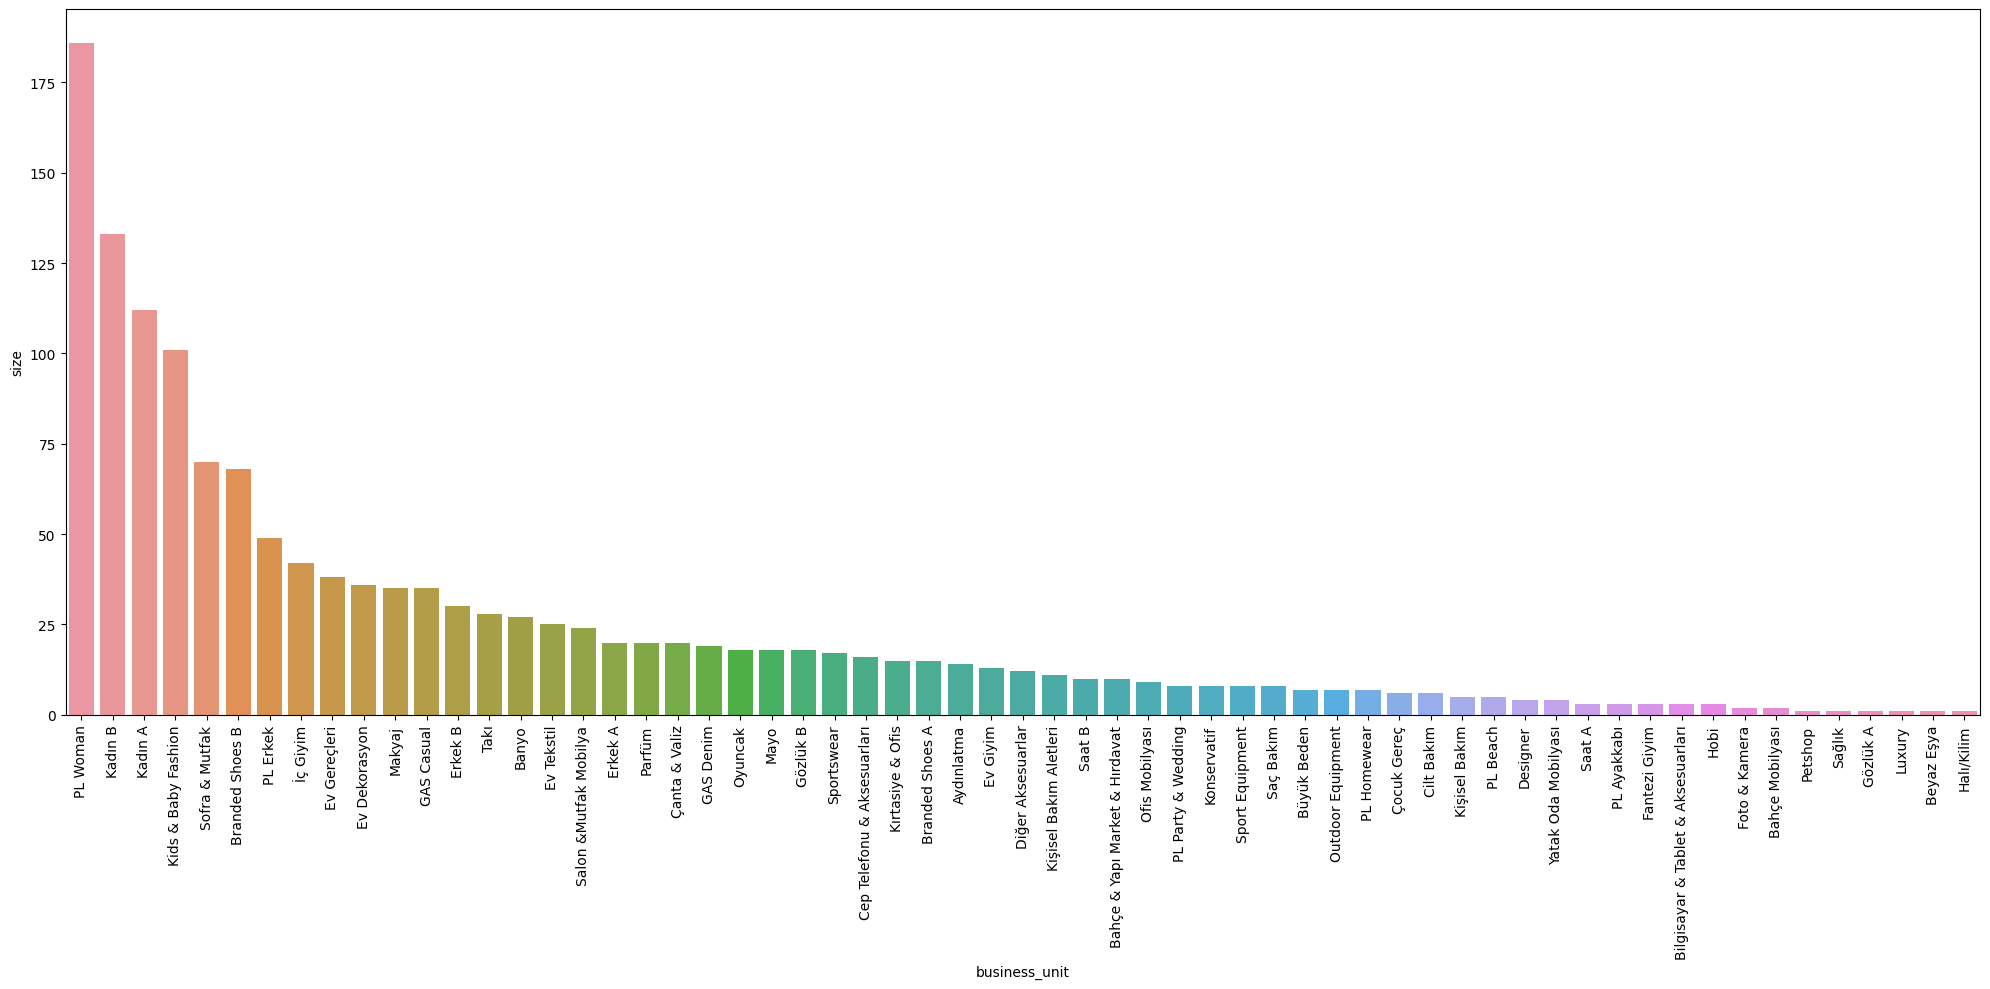

In [62]:
plt.figure(figsize=(20,10))
ax=sns.barplot(x='business_unit',y='size',data=bu.head(100))
plt.xticks(rotation=90)
plt.tight_layout()

## Gender Insight

In [63]:
df[df.gender=='Unisex'].groupby('business_unit').size().sort_values(ascending=False).head(50)

Series([], dtype: int64)

In [64]:
df.gender=df.gender.fillna('Unisex')
gender=pd.DataFrame(df.groupby('gender').size())
gender.rename(columns={0:'size'},inplace=True)
gender.sort_values(by='size',ascending=False,inplace=True)
gender.reset_index(inplace=True)

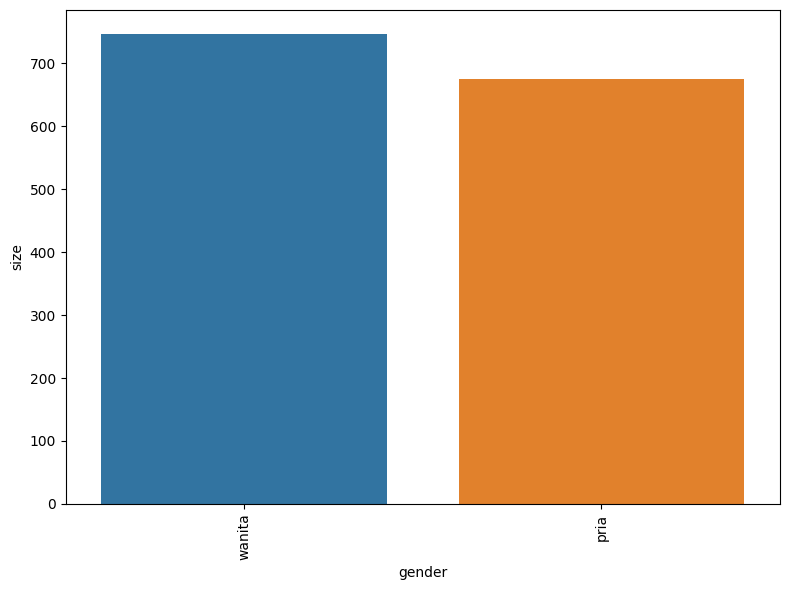

In [65]:
plt.figure(figsize=(8,6))
ax=sns.barplot(x='gender',y='size',data=gender)
plt.xticks(rotation=90)
plt.tight_layout()

## Price Insight

In [66]:
df.price.describe()

count     1422.000000
mean        99.617018
std        387.915838
min          3.000000
25%         33.397500
50%         50.000000
75%         93.810000
max      10678.260000
Name: price, dtype: float64

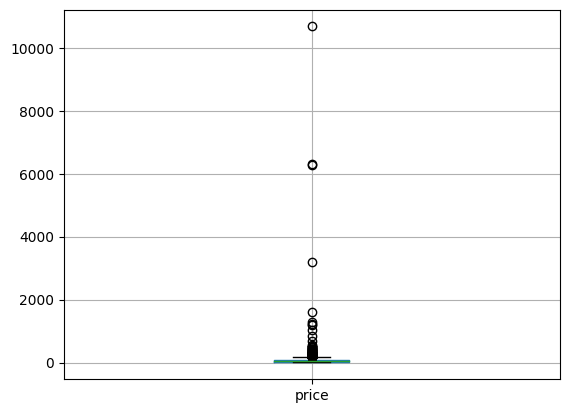

In [67]:
boxplot = df.boxplot(column=['price'])

In [68]:
df[df.price>1000].groupby('category_name').size().sum()

9

There are only 9 products higher than the 1000 TL.

## Normalization


In [69]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Take the "Price" column and reshape it into an array
Price = df['price'].values.reshape(-1, 1)

# Perform Min-Max Scaling on the "Price" column
Price_scaled = scaler.fit_transform(Price)

# Replace the values in the "Price" column with the scaled values
df['price'] = Price_scaled

df.head()

,orderparentid,user_id,productcontentid,brand_id,category_id,category_name,gender,price,color_id,business_unit
0,335057357,86386,39328996,919155,418,speaker,wanita,0.029693,14.0,Branded Shoes B
1,337401625,59469,31903343,121,1827,camera,pria,0.111713,3.0,Bahçe & Yapı Market & Hırdavat
2,338457012,51248,34726400,40,604,matras,wanita,0.003278,14.0,PL Woman
3,336681542,29380,32920640,7651,604,matras,wanita,0.002060,6.0,Kadın A
4,335736916,68368,39035716,3395,599,PS,wanita,0.007204,16.0,Kadın A


## Label Encoding

In [70]:
# Initialize LabelEncoder
#le = LabelEncoder()

# Encoding attribute "gender"
#df['gender'] = le.fit_transform(df['gender'])

# Encoding attribute "category_name"
#df['category_name'] = le.fit_transform(df['category_name'])

#df.head()

## Determining Product Similarities

### Determining Weight For Gender

In [71]:
df_gender=df[['gender','productcontentid']]
df_gender.to_sql("df_gender",conn,if_exists='replace')

1422

In [72]:
gend= pd.read_sql(
    """
    select gender, count(1) n
    from df_gender
    group by gender
    order by n desc
    """,conn
)

gend['g_weight']= gend[['n']].transform(lambda x: x/x.sum())

In [73]:
df1=df.merge(gend,on='gender').drop('n',axis=1)

### Determining Weight For Business Unit

In [74]:
scenario1=df.drop(['orderparentid','user_id','color_id', 'gender','price'],axis=1)

In [75]:
import sqlite3
conn=sqlite3.connect(":memory:")

scenario1.to_sql("scenario1",conn,if_exists='replace')

bu_unit= pd.read_sql(
    """
    select business_unit, count(1) n
    from scenario1
    group by business_unit
    order by n desc
    """,conn
)

In [76]:
bu_unit['b_weight']= bu_unit[['n']].transform(lambda x: x/x.sum())
bu_unit=bu_unit.drop('n',axis=1)
df1=df1.merge(bu_unit,on=['business_unit'])

### Determining Weight For Category 

In [77]:
category=pd.read_sql(
    """
    select business_unit,category_name, count(1) n
    from scenario1
    group by  category_name ,business_unit
    order by n desc
    """
    ,conn)

In [78]:
category['c_weight']=category[['n']].transform(lambda x: x/x.sum())
category=category.drop('n',axis=1)
df1=df1.merge(category,on=['category_name','business_unit'])

### Construct Main Weight For Products

In [79]:
df1['weight'] = df1.c_weight * 0.5 + df1.g_weight * 0.2 + df1.b_weight * 0.3
df1=df1.drop(['c_weight','g_weight','b_weight'],axis=1)

In [80]:
recommendation=df1.sort_values('weight',ascending=False).drop_duplicates(subset=['business_unit','gender'], keep="first").drop_duplicates(subset=['category_name','gender'],keep='first')

In [81]:
recommendation

,orderparentid,user_id,productcontentid,brand_id,category_id,category_name,gender,price,color_id,business_unit,weight
134,334024704,3533,43442672,40,604,matras,wanita,0.003933,7.0,PL Woman,0.172785
530,329941381,106351,39673462,564,1182,tas,wanita,0.004870,14.0,Kadın B,0.140155
270,336143622,1246,44748916,7651,604,matras,pria,0.001592,9.0,Kadın A,0.129817
38,330678335,83930,35770710,708101,975,sepatu,wanita,0.011334,3.0,Branded Shoes B,0.128551
915,335467811,105980,115746,949136,2135,sleeping bag,wanita,0.002061,3.0,Sofra & Mutfak,0.123699
41,328163758,74490,39594841,35621,975,sepatu,pria,0.003457,3.0,Branded Shoes B,0.118425
369,334694637,105336,41136118,969686,550,kustom,wanita,0.001583,14.0,İç Giyim,0.117089
1068,328159306,86785,40192897,28345,839,pemotong rumput,wanita,0.001123,17.0,Banyo,0.115682
783,328217048,101816,1069292,10825,661,laptop,wanita,0.002426,3.0,Parfüm,0.115612
891,337980621,38609,2783735,7821,644,camera,wanita,0.009930,12.0,Makyaj,0.115612


## Convert Textual Data Into a Vector Matrix Product 

In [82]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity
from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [83]:
df2=df1.copy()
df2=df2.sample(1420)

In [84]:
df2['description']=df2.business_unit.str.cat(" "+df2.category_name.str.cat(" "+df2.gender))
df2=df2[['productcontentid','description']]

In [88]:
stopw_turkish = stopwords.words('english') + stopwords.words('turkish')
tf = TfidfVectorizer(analyzer='word',stop_words='english')
tfidf_matrix=tf.fit_transform(df2.description)
cosine_similarities=linear_kernel(tfidf_matrix, tfidf_matrix)

## Cosine Similarity

In [89]:
cosine_similarities=linear_kernel(tfidf_matrix, tfidf_matrix)

In [91]:
df2=df2.reset_index().drop('index',axis=1)
print(df2)

      productcontentid                        description
0             32592102          Ev Dekorasyon kustom pria
1             35557770             PL Woman matras wanita
2             31971320              PL Woman mouse wanita
3             46191274          Branded Shoes B PS wanita
4             40141379          İç Giyim projector wanita
...                ...                                ...
1415          42466620    Çanta & Valiz mesin cuci wanita
1416          36397124  Kids & Baby Fashion matras wanita
1417           6276592       Branded Shoes B tenda wanita
1418          38328985          Ev Dekorasyon matras pria
1419          34315741             PL Woman matras wanita

[1420 rows x 2 columns]


## Feature Representation

In [94]:
# Mengonversi kolom 'productcontentid' menjadi string
df2['productcontentid'] = df2['productcontentid'].astype(str)

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Representasi TF-IDF untuk fitur "Description"
description_tfidf = tfidf_vectorizer.fit_transform(df2['description'])

# Representasi TF-IDF untuk fitur "productcontentid"
productcontentid_tfidf = tfidf_vectorizer.fit_transform(df2['productcontentid'])

# Menampilkan representasi TF-IDF
print("Representasi TF-IDF untuk Deskripsi:")
print(description_tfidf)


Representasi TF-IDF untuk Deskripsi:
  (0, 77)	0.24024520880906639
  (0, 54)	0.5428544940913881
  (0, 23)	0.6401657592661825
  (0, 29)	0.4876259207140482
  (1, 102)	0.3179195895742048
  (1, 61)	0.5312725142825394
  (1, 104)	0.5858996090924953
  (1, 76)	0.5228750311481123
  (2, 66)	0.6835362643168086
  (2, 102)	0.27390757827228235
  (2, 104)	0.5047890985646373
  (2, 76)	0.45048948922159815
  (3, 80)	0.5839080435888142
  (3, 87)	0.5493048242866719
  (3, 15)	0.5493048242866719
  (3, 102)	0.23575372035889594
  (4, 78)	0.713122739727292
  (4, 38)	0.6524779919235288
  (4, 102)	0.25637556072933404
  (5, 64)	0.5815372568647711
  (5, 67)	0.42750633541014965
  (5, 83)	0.5815372568647711
  (5, 61)	0.3167943217457552
  (5, 77)	0.20126730646139684
  (6, 41)	0.6065659318924865
  :	:
  (1414, 87)	0.5390775816381937
  (1414, 15)	0.5390775816381937
  (1414, 77)	0.24563617038892074
  (1415, 22)	0.48730832855460304
  (1415, 63)	0.48730832855460304
  (1415, 101)	0.5001148945709752
  (1415, 107)	0.50011489

In [95]:
print("TF-IDF representation for Preferensi Pengguna:")
print(productcontentid_tfidf)

TF-IDF representation for Preferensi Pengguna:
  (0, 149)	1.0
  (1, 336)	1.0
  (2, 115)	1.0
  (3, 965)	1.0
  (4, 647)	1.0
  (5, 1040)	1.0
  (6, 304)	1.0
  (7, 424)	1.0
  (8, 429)	1.0
  (9, 807)	1.0
  (10, 535)	1.0
  (11, 1017)	1.0
  (12, 501)	1.0
  (13, 101)	1.0
  (14, 104)	1.0
  (15, 146)	1.0
  (16, 689)	1.0
  (17, 391)	1.0
  (18, 628)	1.0
  (19, 346)	1.0
  (20, 522)	1.0
  (21, 451)	1.0
  (22, 1022)	1.0
  (23, 1078)	1.0
  (24, 331)	1.0
  :	:
  (1395, 763)	1.0
  (1396, 1041)	1.0
  (1397, 1077)	1.0
  (1398, 972)	1.0
  (1399, 13)	1.0
  (1400, 531)	1.0
  (1401, 1101)	1.0
  (1402, 148)	1.0
  (1403, 1022)	1.0
  (1404, 558)	1.0
  (1405, 178)	1.0
  (1406, 755)	1.0
  (1407, 538)	1.0
  (1408, 49)	1.0
  (1409, 924)	1.0
  (1410, 100)	1.0
  (1411, 479)	1.0
  (1412, 71)	1.0
  (1413, 23)	1.0
  (1414, 754)	1.0
  (1415, 777)	1.0
  (1416, 408)	1.0
  (1417, 1049)	1.0
  (1418, 551)	1.0
  (1419, 221)	1.0


## Cosine Similarity

In [96]:
# Combine the two representation matrices into one matrix
feature_matrix = sp.hstack((description_tfidf, productcontentid_tfidf))

# Compute similarities between items using cosine similarity
similarities = cosine_similarity(feature_matrix)

# Display the similarity matrix
print("Similarity Matrix:")
print(similarities)

Similarity Matrix:
[[1.         0.         0.         ... 0.         0.38288992 0.        ]
 [0.         1.         0.30919301 ... 0.03868313 0.10906132 0.5       ]
 [0.         0.30919301 1.         ... 0.03332793 0.         0.30919301]
 ...
 [0.         0.03868313 0.03332793 ... 1.         0.         0.03868313]
 [0.38288992 0.10906132 0.         ... 0.         1.         0.10906132]
 [0.         0.5        0.30919301 ... 0.03868313 0.10906132 1.        ]]


## Similarity Clustering

In [97]:
# Grouping Items Based on Similarity
def group_similarities(similarity_matrix, k):
    n_items = similarity_matrix.shape[0]
    similar_items = []

    for i in range(n_items):
        # Get the similarities of item i with other items
        similarities = similarity_matrix[i]

        # Sort the indices of items based on similarity values
        sorted_indices = np.argsort(similarities)[::-1]

        # Get the top k items with the highest similarity
        top_k_indices = sorted_indices[1:k+1]  # Exclude similarity with itself

        # Store the items with the highest similarity in a list
        similar_items.append(top_k_indices)

    return similar_items

# Example usage
k = 5  # Number of top items to be retrieved
similar_items = group_similarities(similarities, k)

# Display the results of similarity grouping
for i, items in enumerate(similar_items):
    print("Item", i+1, ":")
    for item in items:
        print("  - Item", item+1)

Item 1 :
  - Item 600
  - Item 303
  - Item 1403
  - Item 667
  - Item 1419
Item 2 :
  - Item 1420
  - Item 203
  - Item 962
  - Item 959
  - Item 183
Item 3 :
  - Item 751
  - Item 1181
  - Item 948
  - Item 715
  - Item 349
Item 4 :
  - Item 1324
  - Item 821
  - Item 163
  - Item 1040
  - Item 1175
Item 5 :
  - Item 1066
  - Item 581
  - Item 516
  - Item 529
  - Item 242
Item 6 :
  - Item 943
  - Item 333
  - Item 758
  - Item 6
  - Item 1272
Item 7 :
  - Item 168
  - Item 294
  - Item 683
  - Item 1245
  - Item 1207
Item 8 :
  - Item 8
  - Item 1221
  - Item 486
  - Item 852
  - Item 1381
Item 9 :
  - Item 949
  - Item 1155
  - Item 1171
  - Item 493
  - Item 404
Item 10 :
  - Item 1003
  - Item 629
  - Item 528
  - Item 1180
  - Item 268
Item 11 :
  - Item 1356
  - Item 1125
  - Item 494
  - Item 57
  - Item 206
Item 12 :
  - Item 1304
  - Item 203
  - Item 808
  - Item 922
  - Item 962
Item 13 :
  - Item 13
  - Item 1078
  - Item 214
  - Item 1344
  - Item 1193
Item 14 :
  - Ite

# Content Based Filtering
------

In [98]:
def content_based_filtering(item_id, similar_items, df):
    recommendations = []

    for item in similar_items[item_id]:
        recommendations.append(item)

    # Remove the item itself from the recommendations list
    recommendations = list(set(recommendations) - set([item_id]))

    # Get the product data based on the IDs if the IDs exist in the DataFrame index
    recommended_products = df[df.index.isin(recommendations)]

    return recommended_products

## Example Usage: Content-Based Filtering for Recommending Products".

In [110]:
print(df1.loc[1])

# Example usage
item_id = 1  # ID of the item to be recommended
recommended_products = content_based_filtering(item_id, similar_items, df2)

# Displaying recommended products
print("\n Recommended Products for Item", item_id+1, ":")
recommended_products

orderparentid             325533214
user_id                       33340
productcontentid           43352119
brand_id                      16728
category_id                     418
category_name               speaker
gender                       wanita
price                      0.009071
color_id                        3.0
business_unit       Branded Shoes B
weight                     0.122574
Name: 1, dtype: object

 Recommended Products for Item 2 :


,productcontentid,description
182,35627439,PL Woman matras wanita
202,5888557,PL Woman matras wanita
958,35771539,PL Woman matras wanita
961,37484928,PL Woman matras wanita
1419,34315741,PL Woman matras wanita


In [111]:
print(df1.loc[562])

# Example usage
item_id = 562  # ID of the item to be recommended
recommended_products = content_based_filtering(item_id, similar_items, df2)

# Displaying recommended products
print("\n Recommended Products for Item", item_id+1, ":")
recommended_products

orderparentid                 327855205
user_id                           51865
productcontentid               35488032
brand_id                           3268
category_id                         531
category_name              lampu studio
gender                           wanita
price                          0.001592
color_id                            8.0
business_unit       Kids & Baby Fashion
weight                         0.129536
Name: 562, dtype: object

 Recommended Products for Item 563 :


,productcontentid,description
97,7081311,Sportswear matras pria
138,5044674,Sportswear laptop pria
153,6084885,Sportswear laptop pria
844,7081302,Sportswear tenda pria
1301,34176696,Sportswear matras wanita


In [112]:
print(df1.loc[31])

# Example usage
item_id = 31  # ID of the item to be recommended
recommended_products = content_based_filtering(item_id, similar_items, df2)

# Displaying recommended products
print("\n Recommended Products for Item", item_id+1, ":")
recommended_products

orderparentid             334161990
user_id                       34055
productcontentid           34826777
brand_id                       8820
category_id                     975
category_name                sepatu
gender                       wanita
price                      0.009681
color_id                       14.0
business_unit       Branded Shoes B
weight                     0.128551
Name: 31, dtype: object

 Recommended Products for Item 32 :


,productcontentid,description
23,6699427,Makyaj pemotong rumput pria
150,32196604,Bahçe Mobilyası pemotong rumput pria
911,31709161,Takı pemotong rumput pria
1300,31575259,Banyo pemotong rumput pria
1379,36399948,İç Giyim pemotong rumput pria


In [113]:
print(df1.loc[900])

# Example usage
item_id = 900  # ID of the item to be recommended
recommended_products = content_based_filtering(item_id, similar_items, df2)

# Displaying recommended products
print("\n Recommended Products for Item", item_id+1, ":")
recommended_products

orderparentid       338494930
user_id                 65496
productcontentid      4502849
brand_id                20010
category_id               647
category_name          sepatu
gender                 wanita
price                0.002037
color_id                  3.0
business_unit          Makyaj
weight               0.115612
Name: 900, dtype: object

 Recommended Products for Item 901 :


,productcontentid,description
358,4499448,Sofra & Mutfak tripod pria
675,36471688,Sofra & Mutfak tripod pria
734,32411015,Sofra & Mutfak tripod pria
905,6806606,Sofra & Mutfak tripod pria
949,36471688,Sofra & Mutfak tripod pria


## Evaluate Model

In [114]:
def evaluate_model(actual_recommendations, predicted_recommendations):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for i in range(len(actual_recommendations)):
        actual = set(actual_recommendations[i])
        if i < len(predicted_recommendations):  
            predicted = set(predicted_recommendations[i])
            true_positives += len(actual.intersection(predicted))
            false_positives += len(predicted.difference(actual))
            false_negatives += len(actual.difference(predicted))
        else:
            false_negatives += len(actual)  

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Perhitungan akurasi
    total_predictions = true_positives + false_positives
    accuracy = true_positives / total_predictions if total_predictions != 0 else 0

    return precision, recall, f1_score, accuracy

In [118]:
#SPLIT DATA
train_data, test_data = train_test_split(df2, test_size=0.2, random_state=42)


# Use the model to make recommendations on the test data
recommendations = []
for item_id in test_data.index:
    if any(item_id in items for items in similar_items):
        recommended_products = content_based_filtering(item_id, similar_items, train_data)
        recommendations.append(recommended_products)

# Convert the model's recommendation data to a list
predicted_recommendations = recommended_products['description'].tolist()
# Evaluate the model's performance with the test data
actual_recommendations = test_data['description'].tolist()
precision, recall, f1_score, accuracy = evaluate_model(actual_recommendations, predicted_recommendations)

# Display the evaluation results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Accuracy: 0.42857142857142855
Precision: 0.42857142857142855
Recall: 0.0028476506881822496
F1-score: 0.005657708628005658
